In [2]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

df = pd.read_csv("diabetes.csv")
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std    


Missing Values:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


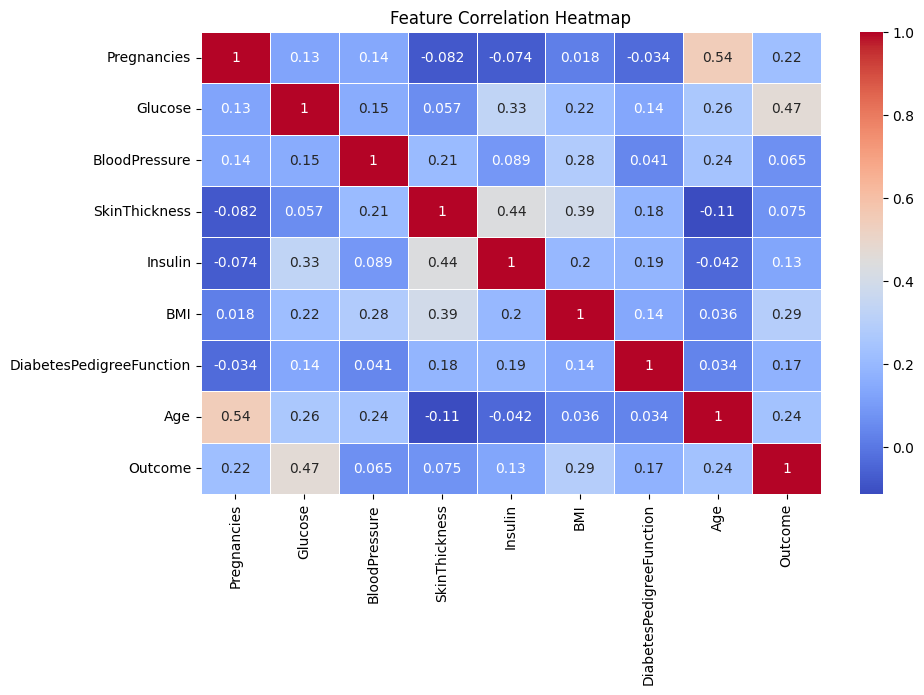

C:\Users\Bhavya\AppData\Local\Temp\ipykernel_16276\2363428904.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Outcome", data=df, palette="Set2")


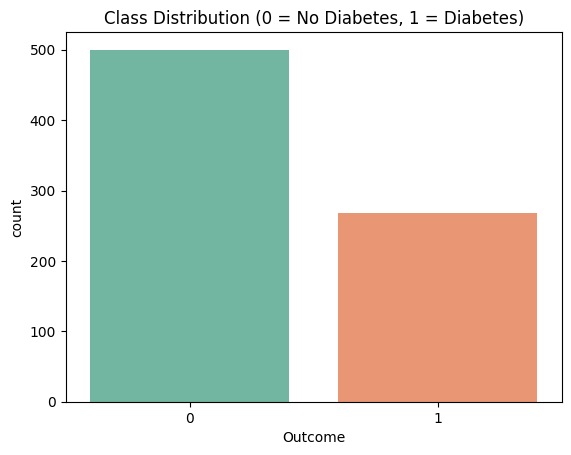

In [3]:
print("\nMissing Values:\n", df.isnull().sum())

plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

sns.countplot(x="Outcome", data=df, palette="Set2")
plt.title("Class Distribution (0 = No Diabetes, 1 = Diabetes)")
plt.show()

In [4]:
X = df.drop(columns=["Outcome"]) 
y = df["Outcome"]  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", n_estimators=100, max_depth=5, random_state=42),  # FIXED
    "SVM": SVC(kernel="linear", probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42)
}


In [5]:
param_grid = {"n_estimators": [50, 100, 150], "max_depth": [5, 10, 15]}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring="accuracy")  # CV = 3 for speed
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
models["Tuned Random Forest"] = best_rf

results = {}
roc_auc_scores = {}


🔹 Random Forest Accuracy: 0.76
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       100
           1       0.67      0.61      0.64        54

    accuracy                           0.76       154
   macro avg       0.74      0.73      0.73       154
weighted avg       0.76      0.76      0.76       154



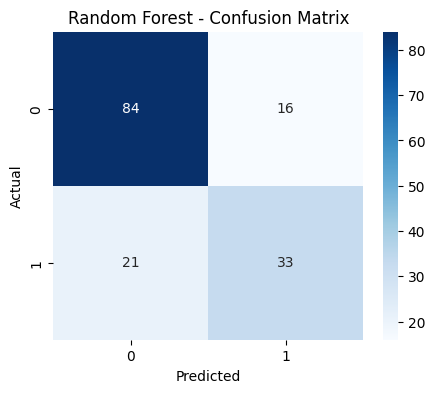

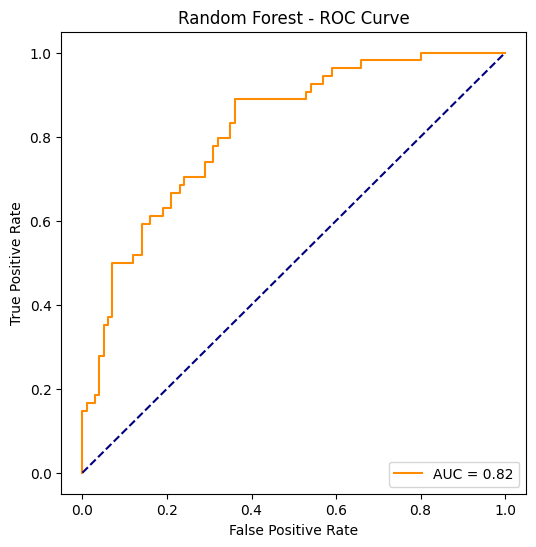


🔹 XGBoost Accuracy: 0.73
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       100
           1       0.63      0.59      0.61        54

    accuracy                           0.73       154
   macro avg       0.71      0.70      0.70       154
weighted avg       0.73      0.73      0.73       154



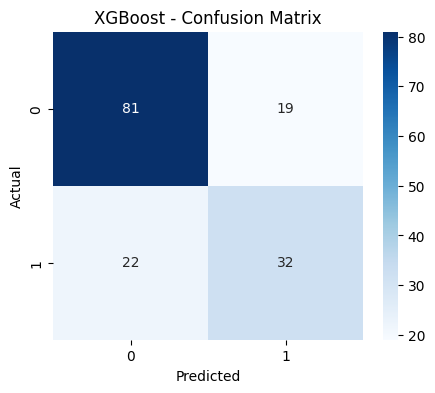

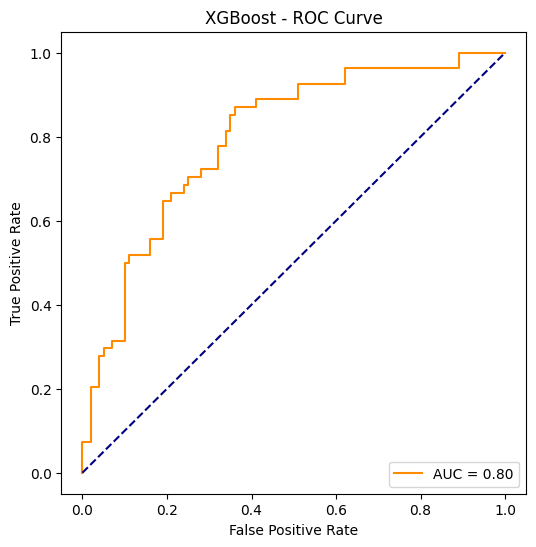


🔹 SVM Accuracy: 0.72
              precision    recall  f1-score   support

           0       0.76      0.83      0.79       100
           1       0.62      0.52      0.57        54

    accuracy                           0.72       154
   macro avg       0.69      0.67      0.68       154
weighted avg       0.71      0.72      0.71       154



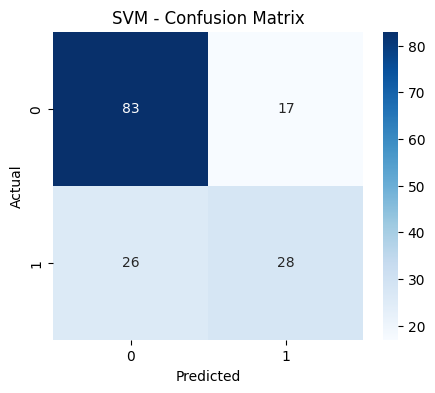

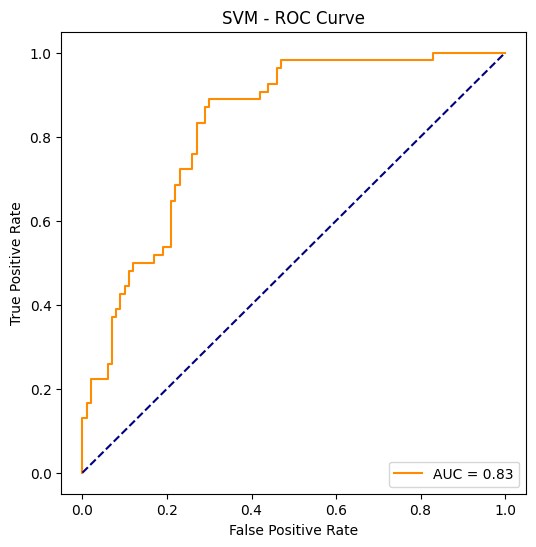


🔹 Logistic Regression Accuracy: 0.71
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       100
           1       0.61      0.52      0.56        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.67       154
weighted avg       0.71      0.71      0.71       154



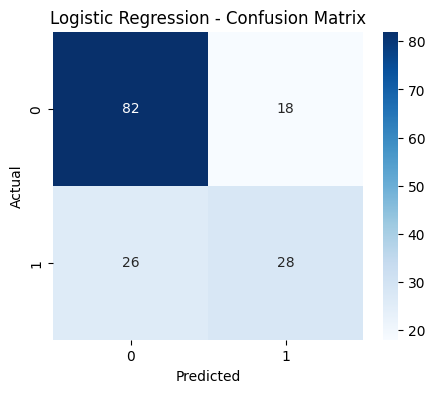

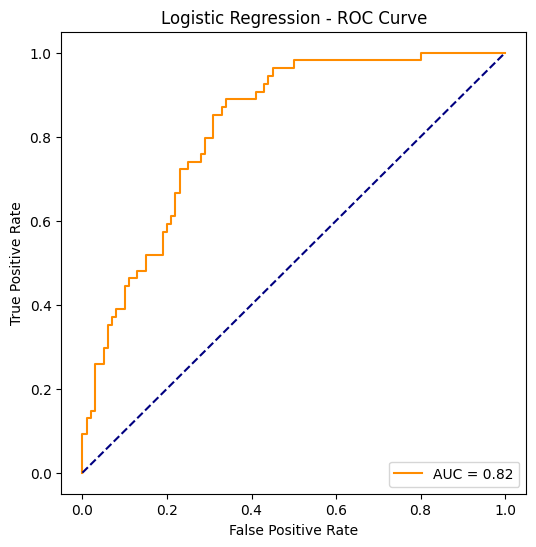


🔹 Tuned Random Forest Accuracy: 0.73
              precision    recall  f1-score   support

           0       0.76      0.85      0.80       100
           1       0.64      0.50      0.56        54

    accuracy                           0.73       154
   macro avg       0.70      0.68      0.68       154
weighted avg       0.72      0.73      0.72       154



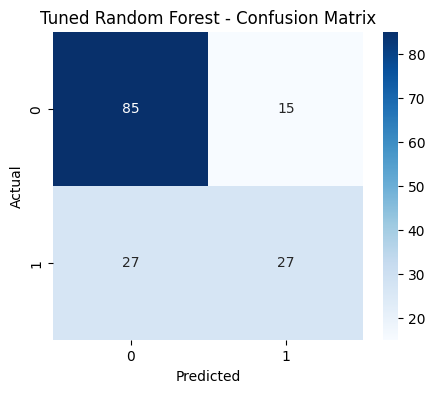

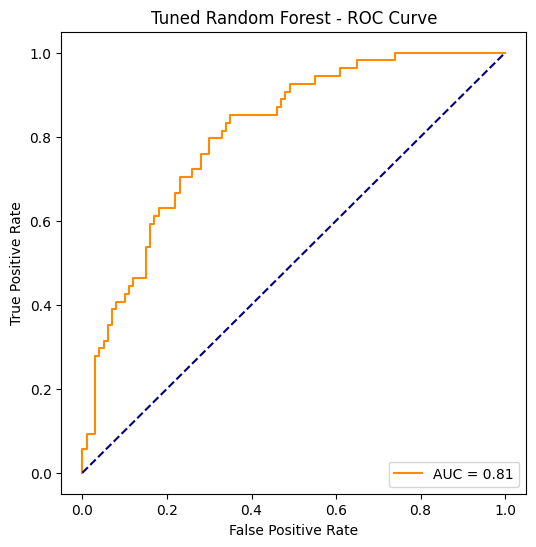

In [6]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"\n🔹 {name} Accuracy: {acc:.2f}")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    if y_pred_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        roc_auc_scores[name] = roc_auc

        plt.figure(figsize=(6, 6))
        plt.plot(fpr, tpr, color="darkorange", label=f"AUC = {roc_auc:.2f}")
        plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
        plt.title(f"{name} - ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.show()

C:\Users\Bhavya\AppData\Local\Temp\ipykernel_16276\52278014.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette="viridis")


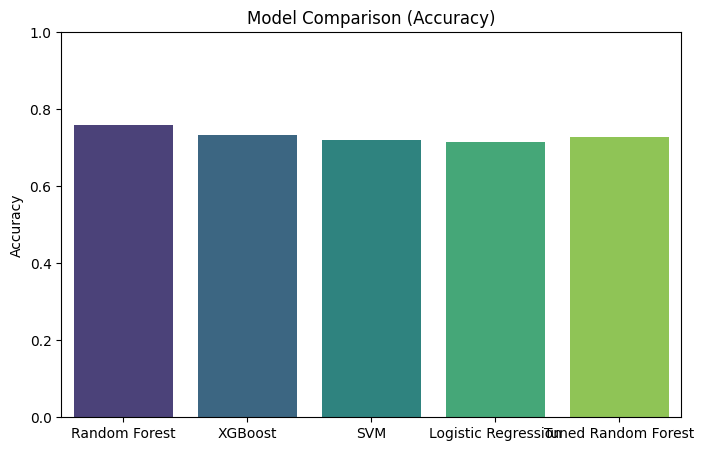

In [7]:
plt.figure(figsize=(8, 5))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette="viridis")
plt.title("Model Comparison (Accuracy)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

C:\Users\Bhavya\AppData\Local\Temp\ipykernel_16276\2570790612.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(roc_auc_scores.keys()), y=list(roc_auc_scores.values()), palette="coolwarm")


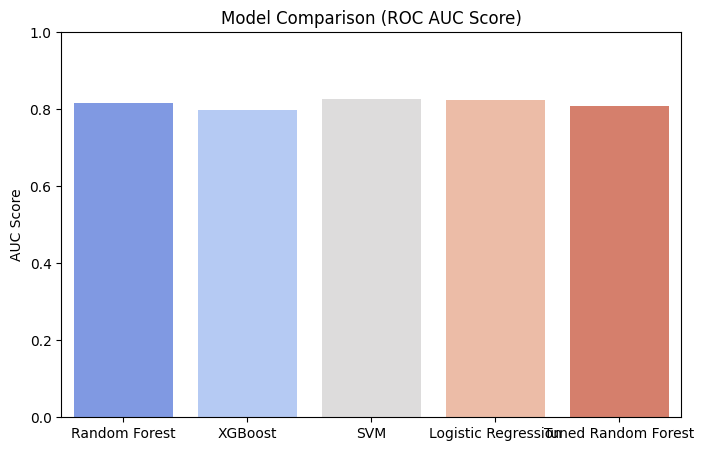

In [8]:
if roc_auc_scores:
    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(roc_auc_scores.keys()), y=list(roc_auc_scores.values()), palette="coolwarm")
    plt.title("Model Comparison (ROC AUC Score)")
    plt.ylabel("AUC Score")
    plt.ylim(0, 1)
    plt.show()